## Preparación de los datos

En [este tutorial](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0), se explica el procedimiento (en inglés).

Primero importamos las librerías y funciones que vamos a utilizar.

In [1]:
#Librerias de machine learning
import torch #PyTorch
import torchvision 
#Libreria para procesar imágenes para ML
import numpy as np #Librería para hacer operaciones vectoriales y matriciales
import torch.nn as nn #Librería de torch con funciones para hacer cosas con redes neuronales
import torch.nn.functional as F #Lo mismo que nn pero le pasas los argumentos DENTRO de la funcion
import torchvision.transforms #Sirve para hacer transformaciones a la imágenes por ej rotaciones 
from torchvision.datasets import MNIST #Dataset que vamos a usar. Lo importamos desde PyTorch
from torch.utils.data.dataloader import DataLoader #Sirve para cargar los datos
from torch.utils.data import random_split #Sirve para partir listas de manera aleatoria

#Librerias para plotear
from torchvision.utils import make_grid #para hacer un ploteo con varias imagenes del dataset
import matplotlib.pyplot as plt
%matplotlib inline

import time

Descargamos los datos y creamos un dataset de PyTorch. Los datos serán imágenes de 28x28 píxeles en blanco y negro (es decir, cada imágen será una matriz 28x28x1) de números escritos. Este famoso conjunto de datos se denomina `MNIST` y es una clase dentro de la librería `torchvision.datasets`, de donde lo descargaremos. Vamos a utilizar un conjunto de imagenes para el entrenamiento y otro con imágenes distintas para el testeo o evaluación.

In [2]:
# Load and transform data
train_ds = MNIST(root='/tmp', 
                 train=True, 
                 download=True, 
                 transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),#transforma la img a tensores (matrices)
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))]) #normaliza 
                  )

test_ds = MNIST(root='/tmp', 
                train=False, 
                download=True, 
                transform=torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),#transforma la img a tensores (matrices)
                          torchvision.transforms.Normalize((0.1307,), (0.3081,))]) #normaliza 
                  )

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw


Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw


Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw
Processing...


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629401553/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Veamos la longitud de cada dataset:

In [3]:
len(train_ds),len(test_ds)

(60000, 10000)

Ahora, usamos la función random_split para separar el conjunto de entrenamiento (60000 imagenes) en dos:

Conjunto de entrenamiento(train): contendrá 80% del total de imagenes en train_ds.

Conjunto de validacióno(val): contendrá el restante 20% del total de imagenes en train_ds.

Ambos subconjuntos se utilizaran *durante* el entrenamiento. El conjunto de testeo NO se utilizará durante el entreamientp, si no despues de concluir con el mismo.

In [4]:
train_size = 48000
val_size = len(train_ds)- train_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(48000, 12000)

Creamos los 'PyTorch data loaders' para el cojunto de entrenamiento y validación. Básicamente son funciones que ya vienen incluidas en PyTorch mediante las cuales podremos ordenar los datos y realizar un entrenamiento en mini-batches (lotes) del tamaño que elijamos, entre otras funcionaliades. Por ejemplo:

- shuffle (bool): Sirve para indicar si queremos que los datos se reorganicen luego de cada epoca de corrida.
- num_workers (int, optional): Cuántos subprocesos usar para la carga de los datos. 0 significa que los datos se cargarán en el proceso principal. 
- pin_memory (bool, optional): Si está en True, el data loader va a copiar los Tensores en la memoria  CUDA antes de devoverlos. Sirve particularmente si vamos a usar el acelerador. 

Más documentación: https://pytorch.org/docs/stable/data.html

In [5]:
#Defino tamaño de los batch
batch_size=24   

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

Vamos a plotear un minibatch de imagenes. Para ello utilizamos la función `make_grid` de `torchvision` y el método `.permute`. Necesitamos este último porque la forma del tensor de las imágenes cargadas en el dataloader es [1,28,28], es decir que los canales están el la dimensión '0' del tensor (la primera). Pero la función `make_grid` toma como argumento tensores (imágenes) de la forma [ancho, alto, canales], por lo que si no hacemos este cambio con las dimensiones la funcion tira un error. Por lo tanto, con el método permute le pedimos que para cada tensor del dataloader, haga el siguiente cambio antes de pasarle en tensor a la función `make_grid`:

canales dim 0-> dim 2

ancho   dim 1-> dim 0

alto    dim2 -> dim 1

images.shape: torch.Size([24, 1, 28, 28])


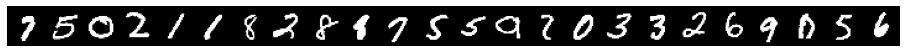

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=100).permute((1, 2, 0)))
    break

## Modelo

Antes que nada, vamos a definir la clase Flatten que simplemente usa la funcion view(input.size(0), -1) para 'aplastar' las imagenes, es decir convertir las matrices en un vector unidimensional. Podríamos usar directamente la función pero es mucho texto. Necesitamos hacer esto porque las funciones que vamos a usar en el modelo son lineales, toman vectores, osea tensores de dimension 1x(largo), no matrices.

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

flatten = Flatten() #creo un objeto de la clase

In [8]:
#def accuracy(outputs, labels):
#    _, preds = torch.max(outputs, dim=1)
#    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#The accuracy we will define our own, that will be basically 
#the number of matched pixels (output == original) divided by the total number of pixels in a batch
def accuracy(outputs, yb):
    return torch.sum(torch.eq(outputs[1], yb)).item()/outputs[1].nelement()

Ahora si, el modelo:

* Usaremos la función `nn.Linear`. Cada vez que usamos una de estas en la red, se dice que es una 'capa' de la misma.

* La primera capa (hidden layer) transformará la matriz de entrada, cuyo tamaño será `batch_size x 784`(luego de pasarla por Flatten) en una matriz intermedia de tamaño `batch_size x hidden_size`, donde `hidden_size` es un parámetro que le pasaremos de antemano a la función, el tamaño de la capa oculta.

* Luego le pasamos la salida de esta funcion a la función `Dropout(p).` Esto 'apaga' algunas conexiones de manera aleatoria, con una probabilidad p. Es un método que sirve para mejorar la performance del modelo. El tamaño se conserva.

* Luego le pasamos la salida a una función de activación no lineal, en particular elegiremos la ReLU(). 

* Al resultado que sale de la función activación, de tamaño `batch_size x hidden_size`, se lo pasamos a la segunda capa denominada 'output layer', que es la capa final y se ocupará de transformar la salida en una matriz de tamaño  `batch_size x 784` identico al tamaño de la entrada inicial, ya que de eso se trata el autoencoder.

In [9]:
class AutoencoderMNIST(nn.Module): 
    """
    Autoencoder es una subclase de la clase Module
    Red neuronal feedforward con 1 capa oculta
    """
    def __init__(self, hidden_size, in_size=784, out_size=784): 
        #los argumentos son los que le voy a pasar a la clase Autoencoder cuando la llame
        super().__init__() #uso esto porque la clase Autoencoder es subclase de otra
        param = locals()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        #Dropuot
        self.drop = nn.Dropout(0.1)
        #Funcion de activación no lineal
        self.relu = nn.ReLU()
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        #droput 
        out = self.drop(out)
        # Apply activation function
        out = self.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                     # Generate predictions
        loss = F.mse_loss(out,flatten(images)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                        # Generate predictions
        loss = F.mse_loss(out, flatten(images))   # Calculate loss ([1, 1, 28, 28])
       # acc = accuracy(out, images.view(-1, 784))          # Calculate accuracy
        return {'val_loss': loss}  # val_acc acc
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        #batch_accs = [x['val_acc'] for x in outputs]
        #epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()} # 'val_acc': epoch_acc.item()
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

## Prueba
Crearemos un modelo que contenga una sola capa oculta con 512 activaciones; este no es el entrenamiento definitivo, sólo vamos a ver si el código funciona antes de entrenar.

In [10]:
hidden_size = 512 # se puede cambiar

model = AutoencoderMNIST(hidden_size=512)

Veamos si los tamaños de las salidas son los esperados. 

In [11]:
for t in model.parameters():
    print(t.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([784, 512])
torch.Size([784])


Generemos algunas salidas del modelo, para ver cómo funciona.

In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.mse_loss(outputs, flatten(images))
    #acc = accuracy(outputs, flatten(images))
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
print('image shape in loader ', outputs[:2].data)

Loss: 1.078021764755249
outputs.shape :  torch.Size([24, 784])
Sample outputs :
 tensor([[-0.1677, -0.2901,  0.0549,  ...,  0.2538, -0.3053, -0.2149],
        [-0.1340, -0.2134,  0.0385,  ...,  0.1874, -0.1187, -0.2652]])
image shape in loader  tensor([[-0.1677, -0.2901,  0.0549,  ...,  0.2538, -0.3053, -0.2149],
        [-0.1340, -0.2134,  0.0385,  ...,  0.1874, -0.1187, -0.2652]])


In [13]:
for xb, yb in val_loader:
    print('xb shape', xb.shape)
    print('yb shape', yb.shape)
    break

xb shape torch.Size([24, 1, 28, 28])
yb shape torch.Size([24])


## Entrenando al Modelo

Vamos a definir algunas funciones que servirán para entrenar el modelo. 

El entrenamiento se realizará con un learning rate variable a lo largo de los batches. Se podría hacer con un lr constante haciendo algunas modificacione en el código.

Más documentacion sobre [lr variables](http://https://pytorch.org/docs/stable/optim.html?highlight=one%20cycle#torch.optim.lr_scheduler.OneCycleLR)

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    '''
    Funcion que sirve para evaluar una vez, para probar.
    '''
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  grad_clip=None, opt_func=torch.optim.SGD):
    
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result) #imprime lo que vamos obteniendo por cada epoca
        history.append(result)
    return history

Con lo siguiente podremos ver cómo se desempeña el modelo con un conjunto inicial de pesos. Si vamos a entrenar definitivamente, recomiendo reiniciar el kerne y saltar este paso.

In [15]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.0523829460144043}]

Elegimos los parámetros con los que entrenaremos

In [16]:
epochs = 100
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-4
input_size = 784
batch_size = 50

Volvemos a cargar los datasets en los loaders porque modificamos el tamaño del batch.

In [17]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

Entrenaremos con diferentes tamaños de capas ocultas para después comparar con cuál se desempeña mejor el modelo.

In [18]:
hidden_size0 = 10

model0 = AutoencoderMNIST(hidden_size=hidden_size0)

history0 = [evaluate(model0, val_loader)]
history0

[{'val_loss': 1.0873920917510986}]

In [19]:
start = time.time()

history0 += fit_one_cycle(epochs, max_lr, model0, train_loader, val_loader,grad_clip=grad_clip)

end = time.time()
time0= (end - start)/60 #Wall time

Epoch [0], last_lr: 0.0043, train_loss: 0.9797, val_loss: 0.9305
Epoch [1], last_lr: 0.0050, train_loss: 0.8865, val_loss: 0.8506
Epoch [2], last_lr: 0.0063, train_loss: 0.8176, val_loss: 0.7911
Epoch [3], last_lr: 0.0081, train_loss: 0.7673, val_loss: 0.7490
Epoch [4], last_lr: 0.0104, train_loss: 0.7331, val_loss: 0.7206
Epoch [5], last_lr: 0.0132, train_loss: 0.7099, val_loss: 0.6996
Epoch [6], last_lr: 0.0163, train_loss: 0.6919, val_loss: 0.6818
Epoch [7], last_lr: 0.0199, train_loss: 0.6776, val_loss: 0.6682
Epoch [8], last_lr: 0.0238, train_loss: 0.6673, val_loss: 0.6589
Epoch [9], last_lr: 0.0280, train_loss: 0.6597, val_loss: 0.6511
Epoch [10], last_lr: 0.0325, train_loss: 0.6524, val_loss: 0.6406
Epoch [11], last_lr: 0.0372, train_loss: 0.6411, val_loss: 0.6249
Epoch [12], last_lr: 0.0420, train_loss: 0.6289, val_loss: 0.6131
Epoch [13], last_lr: 0.0470, train_loss: 0.6230, val_loss: 0.6077
Epoch [14], last_lr: 0.0520, train_loss: 0.6208, val_loss: 0.6048
Epoch [15], last_lr:

In [20]:
hidden_size1 = 64 

model1 = AutoencoderMNIST(hidden_size=hidden_size1)

history1 = [evaluate(model1, val_loader)]
history1

[{'val_loss': 1.0530707836151123}]

In [21]:
%%time
start = time.time()

history1 += fit_one_cycle(epochs, max_lr, model1, train_loader, val_loader,grad_clip=grad_clip)

end = time.time()
time1 = (end - start)/60 #Wall time

Epoch [0], last_lr: 0.0043, train_loss: 0.7398, val_loss: 0.5861
Epoch [1], last_lr: 0.0050, train_loss: 0.5477, val_loss: 0.4632
Epoch [2], last_lr: 0.0063, train_loss: 0.4583, val_loss: 0.3868
Epoch [3], last_lr: 0.0081, train_loss: 0.3990, val_loss: 0.3316
Epoch [4], last_lr: 0.0104, train_loss: 0.3547, val_loss: 0.2881
Epoch [5], last_lr: 0.0132, train_loss: 0.3206, val_loss: 0.2544
Epoch [6], last_lr: 0.0163, train_loss: 0.2947, val_loss: 0.2285
Epoch [7], last_lr: 0.0199, train_loss: 0.2751, val_loss: 0.2093
Epoch [8], last_lr: 0.0238, train_loss: 0.2602, val_loss: 0.1947
Epoch [9], last_lr: 0.0280, train_loss: 0.2500, val_loss: 0.1841
Epoch [10], last_lr: 0.0325, train_loss: 0.2420, val_loss: 0.1762
Epoch [11], last_lr: 0.0372, train_loss: 0.2351, val_loss: 0.1689
Epoch [12], last_lr: 0.0420, train_loss: 0.2299, val_loss: 0.1642
Epoch [13], last_lr: 0.0470, train_loss: 0.2256, val_loss: 0.1600
Epoch [14], last_lr: 0.0520, train_loss: 0.2225, val_loss: 0.1571
Epoch [15], last_lr:

In [22]:
hidden_size2 = 128

model2 = AutoencoderMNIST(hidden_size=hidden_size2)

history2 = [evaluate(model2, val_loader)]
history2

[{'val_loss': 1.0602391958236694}]

In [23]:
%%time
start = time.time()

history2 += fit_one_cycle(epochs, max_lr, model2, train_loader, val_loader, grad_clip=grad_clip)

end = time.time()
time2 = (end - start)/60 #Wall time

Epoch [0], last_lr: 0.0043, train_loss: 0.6449, val_loss: 0.4641
Epoch [1], last_lr: 0.0050, train_loss: 0.4302, val_loss: 0.3411
Epoch [2], last_lr: 0.0063, train_loss: 0.3459, val_loss: 0.2708
Epoch [3], last_lr: 0.0081, train_loss: 0.2922, val_loss: 0.2237
Epoch [4], last_lr: 0.0104, train_loss: 0.2547, val_loss: 0.1901
Epoch [5], last_lr: 0.0132, train_loss: 0.2276, val_loss: 0.1662
Epoch [6], last_lr: 0.0163, train_loss: 0.2086, val_loss: 0.1483
Epoch [7], last_lr: 0.0199, train_loss: 0.1942, val_loss: 0.1352
Epoch [8], last_lr: 0.0238, train_loss: 0.1834, val_loss: 0.1249
Epoch [9], last_lr: 0.0280, train_loss: 0.1751, val_loss: 0.1172
Epoch [10], last_lr: 0.0325, train_loss: 0.1690, val_loss: 0.1115
Epoch [11], last_lr: 0.0372, train_loss: 0.1648, val_loss: 0.1062
Epoch [12], last_lr: 0.0420, train_loss: 0.1613, val_loss: 0.1032
Epoch [13], last_lr: 0.0470, train_loss: 0.1581, val_loss: 0.1006
Epoch [14], last_lr: 0.0520, train_loss: 0.1561, val_loss: 0.0984
Epoch [15], last_lr:

In [24]:
hidden_size3 = 256

model3 = AutoencoderMNIST(hidden_size=hidden_size3)

history3 = [evaluate(model3, val_loader)]
history3

[{'val_loss': 1.0539239645004272}]

In [25]:
%%time
start = time.time()

history3 += fit_one_cycle(epochs, max_lr, model3, train_loader, val_loader, grad_clip=grad_clip)

end = time.time()
time3 = (end - start)/60 #Wall time

Epoch [0], last_lr: 0.0043, train_loss: 0.5544, val_loss: 0.3628
Epoch [1], last_lr: 0.0050, train_loss: 0.3377, val_loss: 0.2528
Epoch [2], last_lr: 0.0063, train_loss: 0.2623, val_loss: 0.1953
Epoch [3], last_lr: 0.0081, train_loss: 0.2180, val_loss: 0.1595
Epoch [4], last_lr: 0.0104, train_loss: 0.1883, val_loss: 0.1345
Epoch [5], last_lr: 0.0132, train_loss: 0.1673, val_loss: 0.1168
Epoch [6], last_lr: 0.0163, train_loss: 0.1519, val_loss: 0.1035
Epoch [7], last_lr: 0.0199, train_loss: 0.1399, val_loss: 0.0934
Epoch [8], last_lr: 0.0238, train_loss: 0.1310, val_loss: 0.0856
Epoch [9], last_lr: 0.0280, train_loss: 0.1241, val_loss: 0.0794
Epoch [10], last_lr: 0.0325, train_loss: 0.1189, val_loss: 0.0749
Epoch [11], last_lr: 0.0372, train_loss: 0.1149, val_loss: 0.0712
Epoch [12], last_lr: 0.0420, train_loss: 0.1112, val_loss: 0.0677
Epoch [13], last_lr: 0.0470, train_loss: 0.1086, val_loss: 0.0655
Epoch [14], last_lr: 0.0520, train_loss: 0.1063, val_loss: 0.0637
Epoch [15], last_lr:

In [26]:
hidden_size4 = 512

model4 = AutoencoderMNIST(hidden_size=hidden_size4)

history4 = [evaluate(model4, val_loader)]
history4

[{'val_loss': 1.0538996458053589}]

In [27]:
%%time
start = time.time()

history4 += fit_one_cycle(epochs, max_lr, model4, train_loader, val_loader, grad_clip=grad_clip)

end = time.time()
time4 = (end - start)/60 #Wall time

Epoch [0], last_lr: 0.0043, train_loss: 0.4789, val_loss: 0.2875
Epoch [1], last_lr: 0.0050, train_loss: 0.2648, val_loss: 0.1920
Epoch [2], last_lr: 0.0063, train_loss: 0.2012, val_loss: 0.1468
Epoch [3], last_lr: 0.0081, train_loss: 0.1655, val_loss: 0.1191
Epoch [4], last_lr: 0.0104, train_loss: 0.1415, val_loss: 0.0997
Epoch [5], last_lr: 0.0132, train_loss: 0.1243, val_loss: 0.0855
Epoch [6], last_lr: 0.0163, train_loss: 0.1113, val_loss: 0.0748
Epoch [7], last_lr: 0.0199, train_loss: 0.1013, val_loss: 0.0667
Epoch [8], last_lr: 0.0238, train_loss: 0.0936, val_loss: 0.0602
Epoch [9], last_lr: 0.0280, train_loss: 0.0876, val_loss: 0.0551
Epoch [10], last_lr: 0.0325, train_loss: 0.0827, val_loss: 0.0509
Epoch [11], last_lr: 0.0372, train_loss: 0.0789, val_loss: 0.0475
Epoch [12], last_lr: 0.0420, train_loss: 0.0757, val_loss: 0.0451
Epoch [13], last_lr: 0.0470, train_loss: 0.0733, val_loss: 0.0428
Epoch [14], last_lr: 0.0520, train_loss: 0.0711, val_loss: 0.0408
Epoch [15], last_lr:

## Ploteos

### Error cuadrático medio de validacion

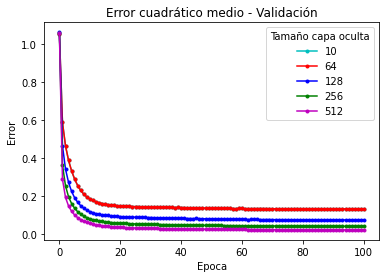

In [28]:
vloss0 = [x['val_loss'] for x in history0]
vloss1 = [x['val_loss'] for x in history1]
vloss2 = [x['val_loss'] for x in history2]
vloss3 = [x['val_loss'] for x in history3]
vloss4 = [x['val_loss'] for x in history4]
plt.plot(vloss0, '-c.', label='10')
plt.plot(vloss1, '-r.', label='64')
plt.plot(vloss2, '-b.', label='128')
plt.plot(vloss3, '-g.', label='256')
plt.plot(vloss4, '-m.', label='512')

plt.xlabel('Epoca')
plt.ylabel('Error')
plt.title('Error cuadrático medio - Validación')
plt.legend(title='Tamaño capa oculta')

### Error cuadrático medio de entrenamiento

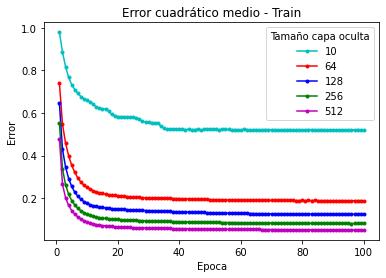

In [29]:
tloss0 = [x.get('train_loss') for x in history0]
tloss1 = [x.get('train_loss') for x in history1]
tloss2 = [x.get('train_loss') for x in history2]
tloss3 = [x.get('train_loss') for x in history3]
tloss4 = [x.get('train_loss') for x in history4]

plt.plot(tloss0, '-c.', label='10')
plt.plot(tloss1, '-r.', label='64')
plt.plot(tloss2, '-b.', label='128')
plt.plot(tloss3, '-g.', label='256')
plt.plot(tloss4, '-m.', label='512')

plt.xlabel('Epoca')
plt.ylabel('Error')
plt.title('Error cuadrático medio - Train')
plt.legend(title='Tamaño capa oculta')

### Función de pérdida vs numero de epoca

Para algun tamaño de capa oculta

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b.')
    plt.plot(val_losses, '-r.')
    plt.xlabel('Epoca')
    plt.ylabel('Error')
    plt.legend(['Training', 'Test']);

Text(0.5, 1.0, 'Capa ocuta = 256')

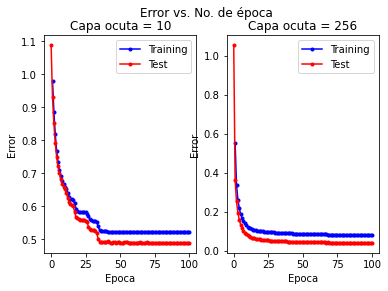

In [31]:
plt.figure()
plt.suptitle('Error vs. No. de época')

plt.subplot(151)
plot_losses(history0)
plt.title('Capa ocuta = 10')

plt.subplot(152)
plot_losses(history1)
plt.title('Capa ocuta = 64')

plt.subplot(153)
plot_losses(history2)
plt.title('Capa ocuta = 128')

plt.subplot(154)
plot_losses(history3)
plt.title('Capa ocuta = 256')

plt.subplot(155)
plot_losses(history4)
plt.title('Capa ocuta = 64')

### Learning rate vs batch

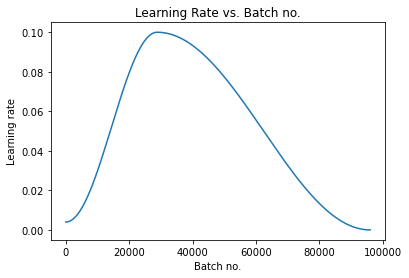

In [32]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history4)

## Testeo
Con las siguientes funciones podremos graficar un autput del modelo junto con la imagen original, de forma que podamos comparar.

In [33]:
#Test
def predict_image(img, model):
    xb = img.unsqueeze(0)  # Convert to a batch of 1
    yb = model(xb) # Get predictions from model
    return yb

Visualizamos una salida que elegimos al azar del conjunto de testeo, para cada capa oculta, co la imagen original correspondiente.

In [34]:
x_test, label = test_ds[9235] #le pasamos el numero de imagen del set de validación

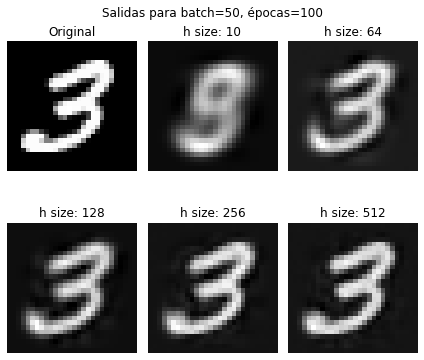

In [35]:
dims=(28,28)

plt.figure(figsize=(6,5.5))
plt.suptitle('Salidas para batch={}, épocas={}'.format(batch_size, epochs))

plt.subplot(231)
plt.imshow(x_test.reshape((28,28)))
plt.gray()
plt.title('Original')
plt.axis('off')

plt.subplot(232)
decoded_img0 = predict_image(x_test,model0).detach().numpy()
plt.imshow(decoded_img0.reshape(dims))
plt.title('h size: {}'.format(hidden_size0))
plt.axis('off')

plt.subplot(233)
decoded_img1 = predict_image(x_test,model1).detach().numpy()
plt.imshow(decoded_img1.reshape(dims))
plt.title('h size: {}'.format(hidden_size1))
plt.axis('off')

plt.subplot(234)
decoded_img2 = predict_image(x_test,model2).detach().numpy()
plt.imshow(decoded_img2.reshape(dims))
plt.title('h size: {}'.format(hidden_size2))
plt.axis('off')

plt.subplot(235)
decoded_img3 = predict_image(x_test,model3).detach().numpy()
plt.imshow(decoded_img3.reshape(dims))
plt.title('h size: {}'.format(hidden_size3))
plt.axis('off')

plt.subplot(236)
decoded_img4 = predict_image(x_test,model4).detach().numpy()
plt.imshow(decoded_img4.reshape(dims))
plt.title('h size: {}'.format(hidden_size4))
plt.axis('off')

plt.tight_layout()
plt.show()
#plot_autoencoder_outputs(img_orig,model1)
#plot_autoencoder_outputs(img_orig,model2)
#plot_autoencoder_outputs(img_orig,model3)
#plot_autoencoder_outputs(img_orig,model4)

## Testeo

Finalmente, vamos a calcular el error sobre el dataset de testeo o evaluación. En general, se espera que sea similar al obtenido para el dataset de validación. Con esto obenemos una nueva métrica para evaluar los resultados.

In [36]:
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

test_result=[]
test_result.append(evaluate(model0, test_loader).get('val_loss'))
test_result.append(evaluate(model1, test_loader).get('val_loss'))
test_result.append(evaluate(model2, test_loader).get('val_loss'))
test_result.append(evaluate(model3, test_loader).get('val_loss'))
test_result.append(evaluate(model4, test_loader).get('val_loss'))

test_result

[0.4857213497161865,
 0.12802986800670624,
 0.07178839296102524,
 0.039141565561294556,
 0.020580794662237167]

## Tabla comparativa

In [37]:
col = ['Capa oculta', 'Minimo error train', 'Minimo error val', 'Error conjunto test', 'Tiempo (min)']
rows = ['%d' % x for x in (10, 64, 128, 256, 512)]
data = [
       [hidden_size0, history0[-1].get('train_loss'), history0[-1].get('val_loss'), test_result[0], time0],
       [hidden_size1, history1[-1].get('train_loss'), history1[-1].get('val_loss'), test_result[1], time1],
       [hidden_size2, history2[-1].get('train_loss'), history2[-1].get('val_loss'), test_result[2], time2],
       [hidden_size3, history3[-1].get('train_loss'), history0[-1].get('val_loss'), test_result[3] ,time3],
       [hidden_size4, history4[-1].get('train_loss'), history0[-1].get('val_loss'), test_result[4] ,time4]
       ]

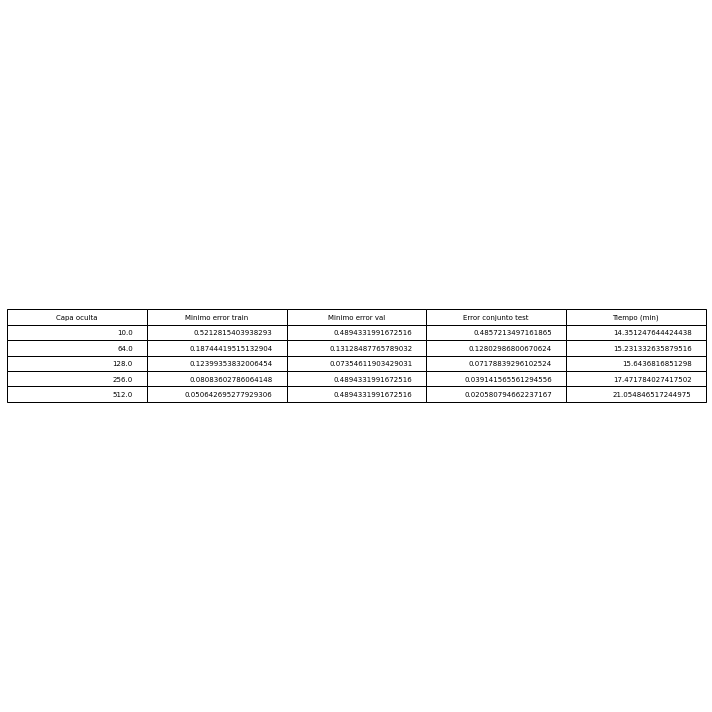

In [38]:
import numpy as np
import pandas as pd

fig, ax = plt.subplots(figsize=(10,10))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame(data, columns=col)

ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()

plt.show()

## Commit and upload the notebook

Finalemente, guardamos el trabajo en Jovian. Esto es muy util si queremos, además de conservar versiones, guardar las métricas de forma simple.

In [39]:
!pip install jovian --upgrade -q

import jovian

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

In [40]:
jovian.reset()

jovian.log_hyperparams(capa_oculta=None,
                       cant_epocas = epochs,
                       lr = max_lr,
                       batch=batch_size,
                       grad_clip = grad_clip)

#jovian.log_metrics(min_train_loss= None,2,  min_val_loss= 0.4668, time = '4min 3s', lr_de_minLoss = 0.0006)

jovian.commit(project='Autoencoder simple', outputs=['Autoencoder simple.pth'], environment=None)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Hyperparams logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/paula-rj/Autoencoder simple


<IPython.core.display.Javascript object>

Fuentes:

[Pytorch: from zero to GANs](http://jovian.ai)

https://nextjournal.com/gkoehler/pytorch-mnist

https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%203%20-%20Autoencoders.ipynb